In [245]:
import matplotlib as plt
import sys
import pandas as pd
import numpy as np
from pathlib import Path
from warnings import simplefilter

import matplotlib.pyplot as plt
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess
from xgboost import XGBRegressor
import seaborn as sns

sys.path.append(r"C:\Users\louis\OneDrive\Documents\CS\BCG Datathon\Datathon_BCG_colissiMONSTRE\datathon_bcg\module")
sys.path.append(r"C:\Users\louis\OneDrive\Documents\CS\BCG Datathon\Datathon_BCG_colissiMONSTRE\datathon_bcg\data\csv\champs")

from datetime import datetime
import pytz

from dataprep import traiter_donnees
from dataprep import completer_heures_manquantes
from dataprep import remplacer_valeurs_manquantes_par_decalage

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
df=pd.read_csv(r"C:\Users\louis\OneDrive\Documents\CS\BCG Datathon\Datathon_BCG_colissiMONSTRE\datathon_bcg\data\csv\champs\champs_2023.csv", delimiter=';')

In [4]:
df=traiter_donnees(df)

In [52]:
df

,Libelle,taux_occupation,etat_arc,debit_horaire
timestamp,,,,
2023-01-01 00:00:00,AV_Champs_Elysees,NaN,Barré,3.0
2023-01-01 01:00:00,AV_Champs_Elysees,NaN,Barré,116.0
2023-01-01 02:00:00,AV_Champs_Elysees,34.44445,Invalide,534.0
2023-01-01 03:00:00,AV_Champs_Elysees,25.47389,Invalide,622.0
2023-01-01 04:00:00,AV_Champs_Elysees,26.02722,Invalide,756.0
...,...,...,...,...
2023-11-30 20:00:00,AV_Champs_Elysees,30.87000,Invalide,1433.0
2023-11-30 21:00:00,AV_Champs_Elysees,24.38111,Invalide,1253.0
2023-11-30 22:00:00,AV_Champs_Elysees,20.40723,Invalide,1069.0


In [16]:
# Compter les valeurs manquantes dans la colonne spécifiée
nombre_de_donnees_manquantes = df["taux_occupation"].isnull().sum()/len(df)

print(f"Le nombre de données manquantes dans la colonne '{'taux_occupation'}' est : {nombre_de_donnees_manquantes}")

nombre_de_donnees_manquantes = df["debit_horaire"].isnull().sum()/len(df)

print(f"Le nombre de données manquantes dans la colonne '{'debit_horaire'}' est : {nombre_de_donnees_manquantes}")

Le nombre de données manquantes dans la colonne 'taux_occupation' est : 0.016755521706016754
Le nombre de données manquantes dans la colonne 'debit_horaire' est : 0.014597613607514598


# Etude de la correlation avec la meteo 

Data meteo historique récupérée : https://public.opendatasoft.com/explore/dataset/donnees-synop-essentielles-omm/export/?sort=date&q.timerange.date=date:%5B2021-08-31T22:00:00Z+TO+2023-12-15T22:59:59Z%5D&q=Paris

Data meteo prediction : https://www.pleinchamp.com/meteo/heure-par-heure/75001-paris/2023-12-03


In [55]:
meteo=pd.read_csv(r'C:\Users\louis\OneDrive\Documents\CS\BCG Datathon\Datathon_BCG_colissiMONSTRE\datathon_bcg\data\meteo.csv', delimiter=';')

In [35]:
meteo.head()

,ID OMM station,Date,Pression au niveau mer,Variation de pression en 3 heures,Type de tendance barométrique,Direction du vent moyen 10 mn,Vitesse du vent moyen 10 mn,Température,Point de rosée,Humidité,...,Altitude,communes (name),communes (code),EPCI (name),EPCI (code),department (name),department (code),region (name),region (code),mois_de_l_annee
0,7149,2021-09-24T02:00:00+02:00,102100,-10.0,0,310,0.5,286.75,284.65,87,...,89,Athis-Mons,91027,Métropole du Grand Paris,200054781,Essonne,91,Île-de-France,11,9
1,7149,2021-09-21T23:00:00+02:00,103010,40.0,3,10,2.7,287.15,283.55,79,...,89,Athis-Mons,91027,Métropole du Grand Paris,200054781,Essonne,91,Île-de-France,11,9
2,7149,2021-09-22T02:00:00+02:00,103010,-10.0,8,360,0.9,285.05,282.75,86,...,89,Athis-Mons,91027,Métropole du Grand Paris,200054781,Essonne,91,Île-de-France,11,9
3,7149,2021-10-11T20:00:00+02:00,102900,50.0,3,360,2.2,285.55,280.05,69,...,89,Athis-Mons,91027,Métropole du Grand Paris,200054781,Essonne,91,Île-de-France,11,10
4,7149,2021-10-12T02:00:00+02:00,102840,-50.0,8,330,2.2,281.75,280.05,89,...,89,Athis-Mons,91027,Métropole du Grand Paris,200054781,Essonne,91,Île-de-France,11,10


In [144]:
def clean_meteo(df):


    # Réduire le DataFrame aux colonnes spécifiées
    nouveau_data = df.loc[:, ['Date', 'Précipitations dans la dernière heure', 'Température (°C)']]
    nouveau_data.dropna(subset=['Date'], inplace=True)

    for i in range (len(nouveau_data)):
        # Convertir la chaîne en objet datetime
        date_time_obj = datetime.fromisoformat(nouveau_data['Date'][i])

        # Formatter la date en chaîne au nouveau format AAAA-MM-JJ HH:MM:SS
        nouveau_format_date = date_time_obj.strftime('%Y-%m-%d %H:%M:%S')

        nouveau_data['Date'][i]=nouveau_format_date
    nouveau_data['Date'] = pd.to_datetime(nouveau_data['Date'])
    nouveau_data = nouveau_data.sort_values(by='Date')
    
        #renommer les colonnes pour que ce soit pratique
    nouveau_data = nouveau_data.rename(columns={'Date': 'timestamp'})


    nouveau_data['timestamp'] = pd.to_datetime(nouveau_data['timestamp'], utc = True)
    nouveau_data['timestamp'] = nouveau_data['timestamp'].dt.tz_convert('Europe/Paris')
    nouveau_data['timestamp'] = nouveau_data['timestamp'].dt.tz_localize(None)
    nouveau_data.set_index('timestamp', inplace=True)
    nouveau_data=completer_heures_manquantes(nouveau_data)

    nouveau_data['precipitations'] = nouveau_data['Précipitations dans la dernière heure']
    nouveau_data['temperature'] = nouveau_data['Température (°C)']


    # Interpoler les valeurs manquantes en utilisant les méthodes de remplissage existantes (pad/ffill et backfill/bfill)
    nouveau_data['precipitations'].fillna(method='bfill', inplace=True)
    nouveau_data['temperature'].fillna(method='bfill', inplace=True)
    nouveau_data.drop(columns=['Précipitations dans la dernière heure','Température (°C)'], inplace=True)

    return nouveau_data

In [145]:
meteo_clean=clean_meteo(meteo)

C:\Users\louis\AppData\Local\Temp\ipykernel_19320\3210833262.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nouveau_data['Date'][i]=nouveau_format_date


In [146]:
meteo_clean

,precipitations,temperature
2021-09-01 04:00:00,0.0,16.0
2021-09-01 05:00:00,0.0,14.5
2021-09-01 06:00:00,0.0,14.5
2021-09-01 07:00:00,0.0,14.5
2021-09-01 08:00:00,0.0,14.8
...,...,...
2023-12-01 16:00:00,0.0,2.5
2023-12-01 17:00:00,0.0,2.5
2023-12-01 18:00:00,0.0,1.3
2023-12-01 19:00:00,0.0,1.3


# Time series

### Trend

In [240]:
data = ["taux_occupation", "debit_horaire"]
df=traiter_donnees(pd.read_csv(r"C:\Users\louis\OneDrive\Documents\CS\BCG Datathon\Datathon_BCG_colissiMONSTRE\datathon_bcg\data\sts_2023.csv", delimiter=';'), arc='sts')
df=remplacer_valeurs_manquantes_par_decalage(df)
df=df.drop(columns=['Libelle','etat_arc'])
df = pd.concat({'Données': df}, names=[None, 'data'], axis=1)

In [241]:
# Load data
data = ["taux_occupation", "debit_horaire"]
df=traiter_donnees(pd.read_csv(r"C:\Users\louis\OneDrive\Documents\CS\BCG Datathon\Datathon_BCG_colissiMONSTRE\datathon_bcg\data\sts_2023.csv", delimiter=';'), arc='sts')
df=remplacer_valeurs_manquantes_par_decalage(df)
df=df.drop(columns=['Libelle','etat_arc'])
df = pd.concat({'Données': df}, names=[None, 'data'], axis=1)

In [242]:
df.head()

Données              
data                taux_occupation debit_horaire
2023-01-01 00:00:00        11.22500         779.0
2023-01-01 01:00:00        11.70944         684.0
2023-01-01 02:00:00        10.65111         734.0
2023-01-01 03:00:00         8.01389         590.0
2023-01-01 04:00:00         5.60778         425.0

In [243]:
# Set Matplotlib defaults
plt.style.use("seaborn-whitegrid")
plt.rc(
    "figure",
    autolayout=True,
    figsize=(11, 4),
    titlesize=18,
    titleweight='bold',
)
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=16,
    titlepad=10,
)
plot_params = dict(
    color="0.75",
    style=".-",
    markeredgecolor="0.25",
    markerfacecolor="0.25",
)

C:\Users\louis\AppData\Local\Temp\ipykernel_19320\3879032101.py:2: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn-whitegrid")


C:\Users\louis\AppData\Local\Temp\ipykernel_19320\2489677616.py:40: UserWarning: When passing multiple axes, sharex and sharey are ignored. These settings must be specified when creating axes.
  axs = y_test.plot(color='0.25', subplots=True, sharex=True, ax=axs)
C:\Users\louis\AppData\Local\Temp\ipykernel_19320\2489677616.py:41: UserWarning: When passing multiple axes, sharex and sharey are ignored. These settings must be specified when creating axes.
  axs = y_fit.plot(color='C0', subplots=True, sharex=True, ax=axs)
C:\Users\louis\AppData\Local\Temp\ipykernel_19320\2489677616.py:42: UserWarning: When passing multiple axes, sharex and sharey are ignored. These settings must be specified when creating axes.
  axs = y_pred.plot(color='C3', subplots=True, sharex=True, ax=axs)


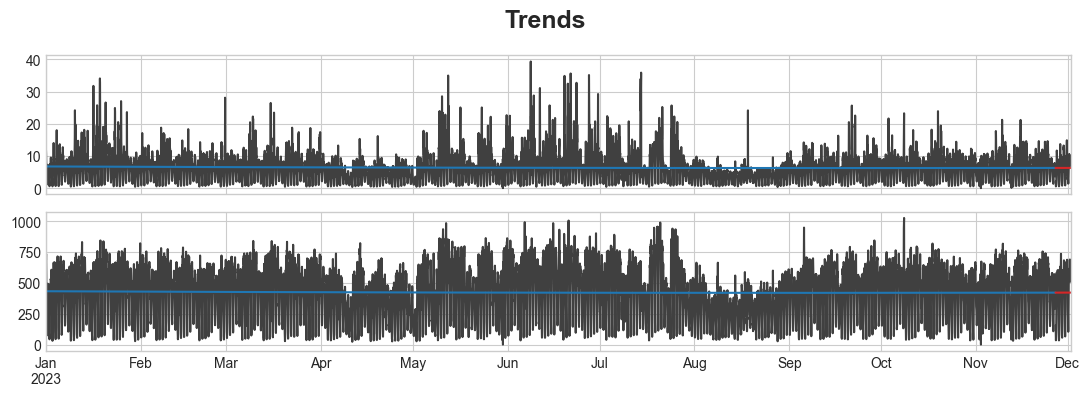

In [244]:
y = df.copy()

y.fillna(0, inplace=True)

# Create trend features
dp = DeterministicProcess(
    index=y.index,  # dates from the training data
    constant=True,  # the intercept
    order=2,        # quadratic trend
    drop=True,      # drop terms to avoid collinearity
)
X = dp.in_sample()  # features for the training data

# Test on the years 2016-2019. It will be easier for us later if we
# split the date index instead of the dataframe directly.
idx_train, idx_test = train_test_split(
    y.index, test_size=24 * 5, shuffle=False,
)
X_train, X_test = X.loc[idx_train, :], X.loc[idx_test, :]
y_train, y_test = y.loc[idx_train], y.loc[idx_test]

# Fit trend model
model = LinearRegression(fit_intercept=False)
model.fit(X_train, y_train)

# Make predictions
y_fit = pd.DataFrame(
    model.predict(X_train),
    index=y_train.index,
    columns=y_train.columns,
)
y_pred = pd.DataFrame(
    model.predict(X_test),
    index=y_test.index,
    columns=y_test.columns,
)

# Plot
axs = y_train.plot(color='0.25', subplots=True, sharex=True)
axs = y_test.plot(color='0.25', subplots=True, sharex=True, ax=axs)
axs = y_fit.plot(color='C0', subplots=True, sharex=True, ax=axs)
axs = y_pred.plot(color='C3', subplots=True, sharex=True, ax=axs)
for ax in axs: ax.legend([])
_ = plt.suptitle("Trends")


In [197]:
df

Données              
data                taux_occupation debit_horaire
2023-01-01 00:00:00             NaN           3.0
2023-01-01 01:00:00             NaN         116.0
2023-01-01 02:00:00        34.44445         534.0
2023-01-01 03:00:00        25.47389         622.0
2023-01-01 04:00:00        26.02722         756.0
...                             ...           ...
2023-11-30 20:00:00        30.87000        1433.0
2023-11-30 21:00:00        24.38111        1253.0
2023-11-30 22:00:00        20.40723        1069.0
2023-11-30 23:00:00        16.66334         950.0
2023-12-01 00:00:00        13.60389         863.0

[8017 rows x 2 columns]

In [233]:
y = df.copy()

y.fillna(0, inplace=True)
# The `stack` method converts column labels to row labels, pivoting from wide format to long

X = y.stack()  # pivot dataset wide to long
display(X.head())
y = X.pop('Données')  # grab target series

Données
                    data                      
2023-01-01 00:00:00 taux_occupation   11.22500
                    debit_horaire    779.00000
2023-01-01 01:00:00 taux_occupation   11.70944
                    debit_horaire    684.00000
2023-01-01 02:00:00 taux_occupation   10.65111

In [234]:
# Turn row labels into categorical feature columns with a label encoding
X = X.reset_index('data')
# Label encoding for 'Industries' feature
for colname in X.select_dtypes(["object", "category"]):
    X[colname], _ = X[colname].factorize()

# Label encoding for annual seasonality
X["Hour"] = X.index.hour  # values are 1, 2, ..., 12

# Create splits
X_train, X_test = X.loc[idx_train, :], X.loc[idx_test, :]
y_train, y_test = y.loc[idx_train], y.loc[idx_test]

In [235]:
# Pivot wide to long (stack) and convert DataFrame to Series (squeeze)
y_fit = y_fit.stack().squeeze()    # trend from training set
y_pred = y_pred.stack().squeeze()  # trend from test set

# Create residuals (the collection of detrended series) from the training set
y_resid = y_train - y_fit

# Train XGBoost on the residuals
xgb = XGBRegressor()
xgb.fit(X_train, y_resid)

# Add the predicted residuals onto the predicted trends
y_fit_boosted = xgb.predict(X_train) + y_fit
y_pred_boosted = xgb.predict(X_test) + y_pred

In [224]:
idx_train

DatetimeIndex(['2023-01-01 00:00:00', '2023-01-01 01:00:00',
               '2023-01-01 02:00:00', '2023-01-01 03:00:00',
               '2023-01-01 04:00:00', '2023-01-01 05:00:00',
               '2023-01-01 06:00:00', '2023-01-01 07:00:00',
               '2023-01-01 08:00:00', '2023-01-01 09:00:00',
               ...
               '2023-11-26 15:00:00', '2023-11-26 16:00:00',
               '2023-11-26 17:00:00', '2023-11-26 18:00:00',
               '2023-11-26 19:00:00', '2023-11-26 20:00:00',
               '2023-11-26 21:00:00', '2023-11-26 22:00:00',
               '2023-11-26 23:00:00', '2023-11-27 00:00:00'],
              dtype='datetime64[ns]', length=7921, freq=None)

C:\Users\louis\AppData\Local\Temp\ipykernel_19320\3439886806.py:5: UserWarning: When passing multiple axes, sharex and sharey are ignored. These settings must be specified when creating axes.
  axs = y_test.unstack(['data']).plot(
C:\Users\louis\AppData\Local\Temp\ipykernel_19320\3439886806.py:8: UserWarning: When passing multiple axes, sharex and sharey are ignored. These settings must be specified when creating axes.
  axs = y_fit_boosted.unstack(['data']).plot(
C:\Users\louis\AppData\Local\Temp\ipykernel_19320\3439886806.py:11: UserWarning: When passing multiple axes, sharex and sharey are ignored. These settings must be specified when creating axes.
  axs = y_pred_boosted.unstack(['data']).plot(


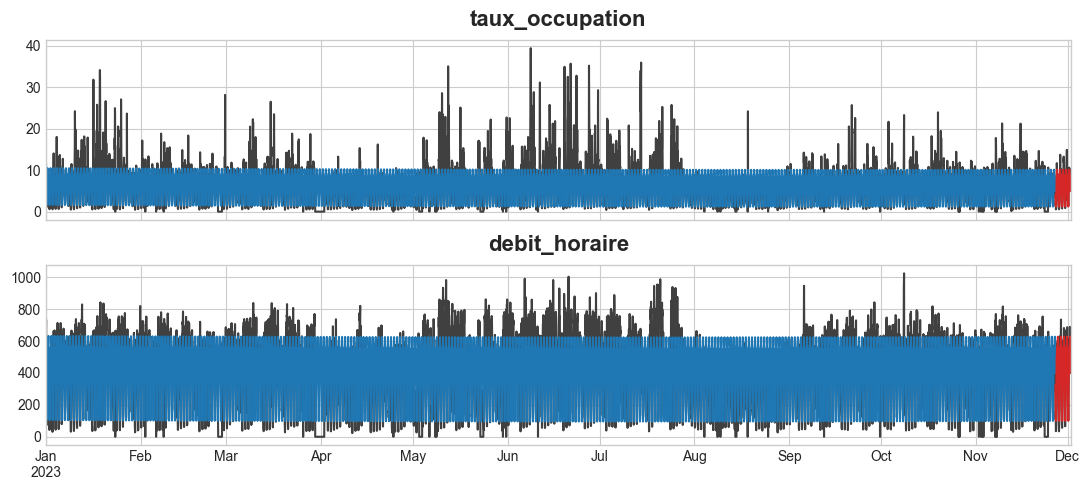

In [236]:
axs = y_train.unstack(['data']).plot(
    color='0.25', figsize=(11, 5), subplots=True, sharex=True,
    title=['taux_occupation', 'debit_horaire'],
)
axs = y_test.unstack(['data']).plot(
    color='0.25', subplots=True, sharex=True, ax=axs,
)
axs = y_fit_boosted.unstack(['data']).plot(
    color='C0', subplots=True, sharex=True, ax=axs,
)
axs = y_pred_boosted.unstack(['data']).plot(
    color='C3', subplots=True, sharex=True, ax=axs,
)
for ax in axs: ax.legend([])

## Saisonnalité - Fourier

In [266]:
df=traiter_donnees(pd.read_csv(r"C:\Users\louis\OneDrive\Documents\CS\BCG Datathon\Datathon_BCG_colissiMONSTRE\datathon_bcg\data\sts_2023.csv", delimiter=';'), arc='sts')
df=remplacer_valeurs_manquantes_par_decalage(df)
df=df.drop(columns=['Libelle','etat_arc'])

In [257]:
def fourier_features(index, freq, order):
    time = np.arange(len(index), dtype=np.float32)
    k = 2 * np.pi * (1 / freq) * time
    features = {}
    for i in range(1, order + 1):
        features.update({
            f"sin_{freq}_{i}": np.sin(i * k),
            f"cos_{freq}_{i}": np.cos(i * k),
        })
    return pd.DataFrame(features, index=index)

In [258]:
def seasonal_plot(X, y, period, freq, ax=None):
    if ax is None:
        _, ax = plt.subplots()
    palette = sns.color_palette("husl", n_colors=X[period].nunique(),)
    ax = sns.lineplot(
        x=freq,
        y=y,
        hue=period,
        data=X,
        ci=False,
        ax=ax,
        palette=palette,
        legend=False,
    )
    ax.set_title(f"Seasonal Plot ({period}/{freq})")
    for line, name in zip(ax.lines, X[period].unique()):
        y_ = line.get_ydata()[-1]
        ax.annotate(
            name,
            xy=(1, y_),
            xytext=(6, 0),
            color=line.get_color(),
            xycoords=ax.get_yaxis_transform(),
            textcoords="offset points",
            size=14,
            va="center",
        )
    return ax

In [281]:
def plot_periodogram_1(ts, detrend='linear', ax=None):
    from scipy.signal import periodogram
    fs = pd.Timedelta("365D") / pd.Timedelta("1D")
    freqencies, spectrum = periodogram(
        ts,
        fs=fs,
        detrend=detrend,
        window="boxcar",
        scaling='spectrum',
    )
    if ax is None:
        _, ax = plt.subplots()
    ax.step(freqencies, spectrum, color="purple")
    ax.set_xscale("log")
    ax.set_xticks([1, 2, 4, 6, 12, 26, 52, 104])
    ax.set_xticklabels(
        [
            "Annual (1)",
            "Semiannual (2)",
            "Quarterly (4)",
            "Bimonthly (6)",
            "Monthly (12)",
            "Biweekly (26)",
            "Weekly (52)",
            "Semiweekly (104)",
        ],
        rotation=30,
    )
    ax.ticklabel_format(axis="y", style="sci", scilimits=(0, 0))
    ax.set_ylabel("Variance")
    ax.set_title("Periodogram")
    return ax



In [282]:
def plot_periodogram(ts, detrend='linear', ax=None):
    from scipy.signal import periodogram
    fs = pd.Timedelta("28D") / pd.Timedelta("1H")
    freqencies, spectrum = periodogram(
        ts,
        fs=fs,
        detrend=detrend,
        window="boxcar",
        scaling='spectrum',
    )
    if ax is None:
        _, ax = plt.subplots()
    ax.step(freqencies, spectrum, color="purple")
    ax.set_xscale("log")
    ax.set_xticks([1, 4, 28, 56, 672])
    ax.set_xticklabels(
        [
            "Monthly (1)",
            "Weekly ()",
            "Daily (28)",
            "Semi-daily (56)",
            "Hourly (672)",
        ],
        rotation=30,
    )
    ax.ticklabel_format(axis="y", style="sci", scilimits=(0, 0))
    ax.set_ylabel("Variance")
    ax.set_title("Periodogram")
    return ax

In [328]:
X

,taux_occupation,debit_horaire,day,week,dayofyear,hour
2023-01-01 00:00:00,11.22500,779.0,6,52,1,0
2023-01-01 01:00:00,11.70944,684.0,6,52,1,1
2023-01-01 02:00:00,10.65111,734.0,6,52,1,2
2023-01-01 03:00:00,8.01389,590.0,6,52,1,3
2023-01-01 04:00:00,5.60778,425.0,6,52,1,4
...,...,...,...,...,...,...
2023-12-01 20:00:00,9.03222,650.0,4,48,335,20
2023-12-01 21:00:00,8.44000,611.0,4,48,335,21
2023-12-01 22:00:00,7.93500,531.0,4,48,335,22
2023-12-01 23:00:00,6.95222,509.0,4,48,335,23


C:\Users\louis\AppData\Local\Temp\ipykernel_19320\4193405222.py:5: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series. To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  X["week"] = X.index.week  # the seasonal period (period)
C:\Users\louis\AppData\Local\Temp\ipykernel_19320\1565446183.py:5: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', False)` for the same effect.

  ax = sns.lineplot(
C:\Users\louis\AppData\Local\Temp\ipykernel_19320\1565446183.py:5: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', False)` for the same effect.

  ax = sns.lineplot(
C:\Users\louis\AppData\Local\Temp\ipykernel_19320\1565446183.py:5: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', False)` for the same effect.

  ax = sns.lineplot(
C:\Users\louis\AppData\Local\Temp\ipykern

<AxesSubplot: title={'center': 'Seasonal Plot (dayofyear/hour)'}, xlabel='hour', ylabel='taux_occupation'>

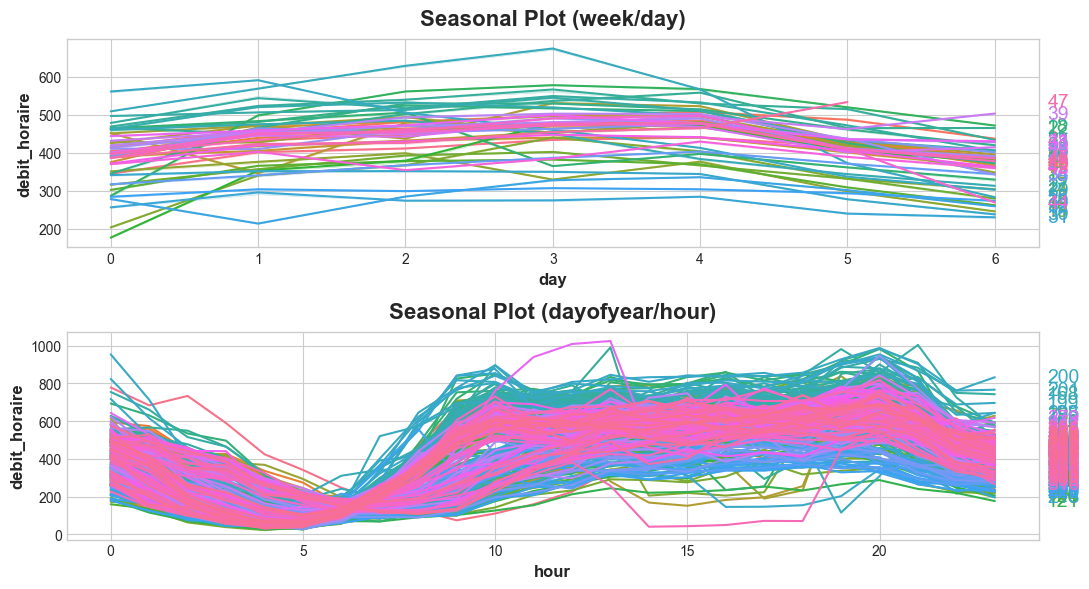

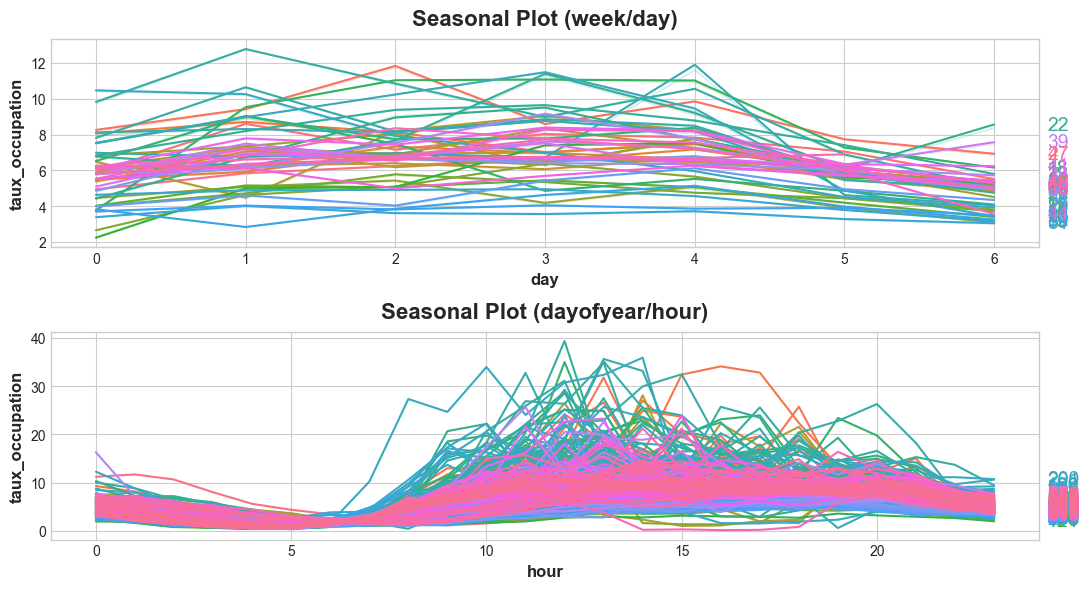

In [327]:
X = df.copy()

# days within a week
X["day"] = X.index.dayofweek  # the x-axis (freq)
X["week"] = X.index.week  # the seasonal period (period)

# days within a year
X["dayofyear"] = X.index.dayofyear
X["hour"] = X.index.hour
fig, (ax0, ax1) = plt.subplots(2, 1, figsize=(11, 6))
seasonal_plot(X, y='debit_horaire', period="week", freq="day", ax=ax0)
seasonal_plot(X, y='debit_horaire', period="dayofyear", freq="hour", ax=ax1)

fig, (ax0, ax1) = plt.subplots(2, 1, figsize=(11, 6))
seasonal_plot(X, y='taux_occupation', period="week", freq="day", ax=ax0)
seasonal_plot(X, y='taux_occupation', period="dayofyear", freq="hour", ax=ax1)

<AxesSubplot: title={'center': 'Periodogram'}, ylabel='Variance'>

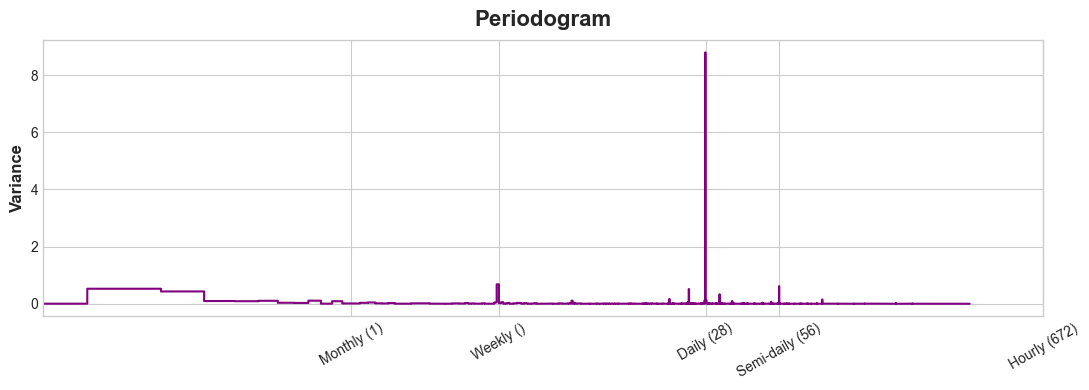

In [293]:
y = df.copy()
y = remplacer_valeurs_manquantes_par_decalage(y)
y.fillna(0, inplace=True)
plot_periodogram(y.taux_occupation)

<AxesSubplot: title={'center': 'Periodogram'}, ylabel='Variance'>

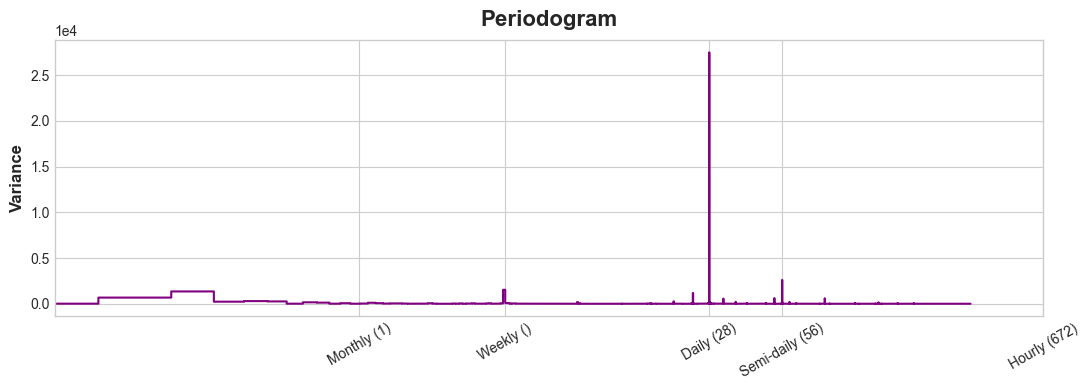

In [287]:
plot_periodogram(y.debit_horaire)

In [321]:
X = df.copy()

In [323]:
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess

fourier = CalendarFourier(freq="168H", order=10)  # 10 sin/cos pairs for "A"nnual seasonality

dp = DeterministicProcess(
    index=df.index,
    constant=True,               # dummy feature for bias (y-intercept)
    order=1,                     # trend (order 1 means linear)
    seasonal=True,               # weekly seasonality (indicators)
    additional_terms=[fourier],  # annual seasonality (fourier)
    drop=True,                   # drop terms to avoid collinearity
)

X = dp.in_sample()  

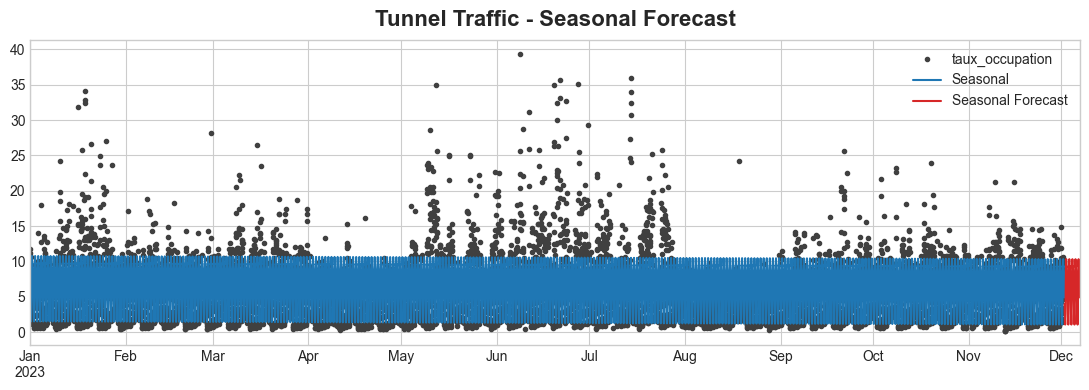

In [325]:


model = LinearRegression(fit_intercept=False)
_ = model.fit(X, y)

y_pred = pd.Series(model.predict(X), index=y.index)
X_fore = dp.out_of_sample(steps=120)
y_fore = pd.Series(model.predict(X_fore), index=X_fore.index)

ax = y.plot(color='0.25', style='.', title="Tunnel Traffic - Seasonal Forecast")
ax = y_pred.plot(ax=ax, label="Seasonal")
ax = y_fore.plot(ax=ax, label="Seasonal Forecast", color='C3')
_ = ax.legend()

### Times features

# Définition de la métrique

In [378]:
def metrique_rmse(y_pred, arc_id : str):
     
    arc_list = {
        'champs' : {'noeud_amont' : 'Av_Champs_Elysees-Washington', 'noeud_aval' : 'Av_Champs_Elysees-Berri'},
     'convention' : {'noeud_amont' : 'Convention-Blomet', 'noeud_aval' : 'Lecourbe-Convention'},
      'sts' : {'noeud_amont' : 'Sts_Peres-Voltaire', 'noeud_aval' : 'Sts_Peres-Universite'},
      }

    assert arc_id in arc_list, f'arc_id must be in {arc_list.keys()}'

    assert y_pred.shape==(120, 2), 'Len(y) must be 120 (5 days) and two columns'

    y_true=traiter_donnees(pd.read_csv(fr'C:\Users\louis\OneDrive\Documents\CS\BCG Datathon\Datathon_BCG_colissiMONSTRE\datathon_bcg\data\{arc_id}_2023.csv', delimiter=';'), arc=arc_id).drop(columns=['Libelle','etat_arc'])[-120:]
    
    assert y_pred.index.equals(y_true.index), 'Mauvaises dates'

    df1=y_true['debit_horaire']
    df2=y_pred['debit_horaire']

    df1, df2 = df1.align(df2, axis=0, join='inner')  # 'axis=0' pour aligner selon les index (lignes), 'join=inner' pour garder uniquement les index en commun

    # Convertir les valeurs en tableaux NumPy pour calculer la RMSE
    values_df1 = df1.values
    values_df2 = df2.values

    # Calculer la différence au carré entre les valeurs des deux DataFrames
    squared_diff = (values_df1 - values_df2) ** 2

    # Calculer la moyenne des différences au carré
    mse = np.mean(squared_diff)

    # Calculer la racine carrée de l'erreur quadratique moyenne (RMSE)
    rmse_debit_horaire = np.sqrt(mse)

    df1=y_true['taux_occupation']
    df2=y_pred['taux_occupation']

    df1, df2 = df1.align(df2, axis=0, join='inner')  # 'axis=0' pour aligner selon les index (lignes), 'join=inner' pour garder uniquement les index en commun

    # Convertir les valeurs en tableaux NumPy pour calculer la RMSE
    values_df1 = df1.values
    values_df2 = df2.values

    # Calculer la différence au carré entre les valeurs des deux DataFrames
    squared_diff = (values_df1 - values_df2) ** 2

    # Calculer la moyenne des différences au carré
    mse = np.mean(squared_diff)

    # Calculer la racine carrée de l'erreur quadratique moyenne (RMSE)
    rmse_taux_occupation = np.sqrt(mse)

    print(f"RMSE for taux_occupation = {rmse_taux_occupation}", 
          f"RMSE for debit_horaire = {rmse_debit_horaire}")





